In [ ]:
import subprocess
import sys

packages = [
    'langchain',
    'sentence-transformers',
    'faiss-cpu',
    'rank-bm25',
    'numpy',
    'pandas',
    'scipy',
    'scikit-learn',
    'google-generativeai'
]

for package in packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])
        print(f"✓ {package} installed")

Installing langchain...
✓ langchain installed
Installing sentence-transformers...
✓ sentence-transformers installed
Installing faiss-cpu...
✓ faiss-cpu installed
Installing rank-bm25...
✓ rank-bm25 installed
✓ numpy already installed
Installing pandas...
✓ pandas installed
✓ scipy already installed
Installing scikit-learn...
✓ scikit-learn installed
Installing google-generativeai...
✓ google-generativeai installed


In [ ]:
import os
import sys
import json
import hashlib
! pip install langchain_community
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple, Any
from datetime import datetime
import logging
from langchain_community.document_loaders import PyPDFLoader
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('RAG-Legal-Bot')

# Add project to path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))

print("✓ Environment configured successfully")
print(f"Project root: {project_root}")

  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_classic-1.0.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached sqlalchemy-2.0.44-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
  Using cached aiohttp-3.13.2-cp313-cp313-win_amd64.whl.metadata (8.4 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.12.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached httpx_sse-0.4.3-py3-none-any.whl.metadata (9.7 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached frozenlist-1.8.0-cp313-cp313-win_amd64.whl.metadata (21 kB)
  Using cached multidict-6.7.0-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached propcache-0.4.1-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached yarl-1.22.0-cp313-cp313-win_amd64.whl.metadata (77 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.me

c:\Users\yash pandey\Desktop\RAG Based legal chatbot\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Environment configured successfully
Project root: C:\Users\yash pandey\Desktop\RAG Based legal chatbot


In [35]:
sample_legal_documents = [
    {
        'id': 'IPC_420',
        'title': 'Indian Penal Code - Section 420',
        'jurisdiction': 'India',
        'category': 'Criminal Law',
        'year': 1860,
        'content': '''Cheating and Dishonestly Inducing Delivery of Property.
        Whoever cheats and thereby dishonestly induces the person deceived to deliver any 
        property to any person, or to make, alter or destroy the whole or any part of a valuable 
        security, or anything which is signed or sealed, with the intent that it may be used as 
        a valuable security, shall be punished with imprisonment of either description for a term 
        which may extend to seven years, and shall also be liable to fine.'''
    },
    {
        'id': 'CPC_154',
        'title': 'Criminal Procedure Code - Section 154',
        'jurisdiction': 'India',
        'category': 'Procedural Law',
        'year': 1973,
        'content': '''Registration of First Information Report (FIR).
        (1) Any person can lodge a First Information Report (FIR) regarding any cognizable offence 
        at the nearest police station.
        (2) The FIR must contain the basic facts and details of the alleged crime and names of 
        the accused if known.
        (3) If the police refuse to register an FIR, the person can approach the Magistrate.'''
    },
    {
        'id': 'IPC_302',
        'title': 'Indian Penal Code - Section 302',
        'jurisdiction': 'India',
        'category': 'Criminal Law',
        'year': 1860,
        'content': '''Punishment for Murder.
        Whoever commits murder shall be punished with imprisonment of either description for a 
        term which may extend to life, or with rigorous imprisonment for a term which may extend 
        to ten years, and shall also be liable to fine, or to both.'''
    }
]

df_documents = pd.DataFrame(sample_legal_documents)
print(f"Loaded {len(df_documents)} legal documents")
print("\nSample documents:")
print(df_documents[['id', 'title', 'jurisdiction', 'category']])

Loaded 3 legal documents

Sample documents:
        id                                  title jurisdiction        category
0  IPC_420        Indian Penal Code - Section 420        India    Criminal Law
1  CPC_154  Criminal Procedure Code - Section 154        India  Procedural Law
2  IPC_302        Indian Penal Code - Section 302        India    Criminal Law


In [38]:
import re

def clean_text(text: str) -> str:
    """Clean and normalize legal text"""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\.\,\:\;\-\(\)\/]', '', text)
    return text.strip()
df_documents['content_clean'] = df_documents['content'].apply(clean_text)

print("Sample cleaned content:")
print(df_documents.loc[0, 'content_clean'][:200] + "...")

Sample cleaned content:
Cheating and Dishonestly Inducing Delivery of Property. Whoever cheats and thereby dishonestly induces the person deceived to deliver any property to any person, or to make, alter or destroy the whole...


In [ ]:
#from langchain_text_splitters import RecursiveCharacterTextSplitter
#splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
def chunk_text(text: str, chunk_size: int = 300, overlap: int = 50) -> List[str]:
    """Split text into chunks with overlap"""
    sentences = re.split(r'(?<=[.!?])\s+', text)
    chunks = []
    current_chunk = []
    current_length = 0
    
    for sentence in sentences:
        if current_length + len(sentence) > chunk_size and current_chunk:
            chunks.append(' '.join(current_chunk))
            current_chunk = [sentence]
            current_length = len(sentence)
        else:
            current_chunk.append(sentence)
            current_length += len(sentence)
    
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks
chunks_list = []
for idx, row in df_documents.iterrows():
    chunks = chunk_text(row['content_clean'])
    for chunk_idx, chunk in enumerate(chunks):
        chunks_list.append({
            'doc_id': row['id'],
            'chunk_id': f"{row['id']}_chunk_{chunk_idx}",
            'title': row['title'],
            'jurisdiction': row['jurisdiction'],
            'category': row['category'],
            'year': row['year'],
            'text': chunk,
            'chunk_num': chunk_idx,
            'total_chunks': len(chunks)
        })

df_chunks = pd.DataFrame(chunks_list)
print(f"Created {len(df_chunks)} chunks from {len(df_documents)} documents")
print("\nChunk distribution:")
print(df_chunks.groupby('doc_id')['chunk_id'].count())

Created 5 chunks from 3 documents

Chunk distribution:
doc_id
CPC_154    2
IPC_302    1
IPC_420    2
Name: chunk_id, dtype: int64


In [ ]:
from sentence_transformers import SentenceTransformer
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
embedder = SentenceTransformer(model_name)
embedding_dim = embedder.get_sentence_embedding_dimension()

print(f"Embedding Model: {model_name}")
print(f"Embedding Dimension: {embedding_dim}")
texts = df_chunks['text'].tolist()
embeddings = embedder.encode(texts, show_progress_bar=True, convert_to_numpy=True)

df_chunks['embedding'] = [emb for emb in embeddings]

print(f"\n✓ Generated embeddings for {len(embeddings)} chunks")
print(f"Embedding shape: {embeddings.shape}")
print(f"Sample embedding (first 5 values): {embeddings[0, :5]}")

2025-11-29 11:32:31,214 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-11-29 11:32:31,215 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Embedding Model: sentence-transformers/all-MiniLM-L6-v2
Embedding Dimension: 384


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


✓ Generated embeddings for 5 chunks
Embedding shape: (5, 384)
Sample embedding (first 5 values): [-0.0385759   0.07901365  0.02970448  0.02613696 -0.03999567]


In [ ]:
import faiss
from typing import List, Tuple
embeddings_array = np.array(embeddings, dtype=np.float32)
faiss_index = faiss.IndexFlatL2(embedding_dim)
faiss_index.add(embeddings_array)

print(f"FAISS Index Type: IndexFlatL2 (Euclidean distance)")
print(f"Total vectors in index: {faiss_index.ntotal}")

# Store metadata mapping
metadata_map = {i: row for i, (_, row) in enumerate(df_chunks.iterrows())}
query_text = "What is the punishment for cheating under Indian law?"
query_embedding = embedder.encode(query_text, convert_to_numpy=True).reshape(1, -1).astype(np.float32)

k = 3
distances, indices = faiss_index.search(query_embedding, k)

print(f"\nQuery: {query_text}")
print(f"\nTop {k} Results:")
for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
    metadata = metadata_map[idx]
    similarity = 1 / (1 + dist) 
    print(f"\n{i+1}. [{similarity:.4f}] {metadata['title']}")
    print(f"   Doc ID: {metadata['doc_id']}")
    print(f"   Text: {metadata['text'][:100]}...")

2025-11-28 10:58:29,579 - faiss.loader - INFO - Loading faiss with AVX2 support.
2025-11-28 10:58:29,764 - faiss.loader - INFO - Successfully loaded faiss with AVX2 support.


FAISS Index Type: IndexFlatL2 (Euclidean distance)
Total vectors in index: 5


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.23it/s]


Query: What is the punishment for cheating under Indian law?

Top 3 Results:

1. [0.5479] Indian Penal Code - Section 420
   Doc ID: IPC_420
   Text: Whoever cheats and thereby dishonestly induces the person deceived to deliver any property to any pe...

2. [0.4901] Indian Penal Code - Section 302
   Doc ID: IPC_302
   Text: Punishment for Murder. Whoever commits murder shall be punished with imprisonment of either descript...

3. [0.4892] Indian Penal Code - Section 420
   Doc ID: IPC_420
   Text: Cheating and Dishonestly Inducing Delivery of Property....


## 8. BM25 Lexical Index

In [42]:
from rank_bm25 import BM25Okapi

# Tokenize documents
def tokenize(text: str) -> List[str]:
    return text.lower().split()

tokenized_corpus = [tokenize(text) for text in df_chunks['text']]

# Build BM25 index
bm25_index = BM25Okapi(tokenized_corpus)

print(f"BM25 Index created with {len(tokenized_corpus)} documents")

# Example BM25 search
query = "punishment cheating indian law"
tokenized_query = tokenize(query)
bm25_scores = bm25_index.get_scores(tokenized_query)

# Get top-k results
top_indices = np.argsort(bm25_scores)[::-1][:k]

print(f"\nBM25 Query: {query}")
print(f"\nTop {k} BM25 Results:")
for i, idx in enumerate(top_indices):
    metadata = metadata_map[idx]
    score = bm25_scores[idx]
    print(f"\n{i+1}. [Score: {score:.4f}] {metadata['title']}")
    print(f"   Text: {metadata['text'][:100]}...")

BM25 Index created with 5 documents

BM25 Query: punishment cheating indian law

Top 3 BM25 Results:

1. [Score: 1.7322] Indian Penal Code - Section 420
   Text: Cheating and Dishonestly Inducing Delivery of Property....

2. [Score: 1.0066] Indian Penal Code - Section 302
   Text: Punishment for Murder. Whoever commits murder shall be punished with imprisonment of either descript...

3. [Score: 0.0000] Criminal Procedure Code - Section 154
   Text: (3) If the police refuse to register an FIR, the person can approach the Magistrate....


In [ ]:
## Hybrid Retrieval & Re-ranking
def hybrid_search(query: str, faiss_weight: float = 0.6, bm25_weight: float = 0.4, k: int = 3):
    """
    Hybrid search combining FAISS semantic and BM25 lexical search
    """
    query_embedding = embedder.encode(query, convert_to_numpy=True).reshape(1, -1).astype(np.float32)
    distances, faiss_indices = faiss_index.search(query_embedding, k)
    
    # Normalize FAISS distances to similarity scores (0-1)
    faiss_scores = {}
    for idx, dist in zip(faiss_indices[0], distances[0]):
        similarity = 1 / (1 + dist)
        faiss_scores[idx] = similarity
    
    # BM25 search
    tokenized_query = tokenize(query)
    bm25_raw_scores = bm25_index.get_scores(tokenized_query)
    
    # Normalize BM25 scores (0-1)
    max_bm25 = np.max(bm25_raw_scores) if np.max(bm25_raw_scores) > 0 else 1
    bm25_scores = {i: score / max_bm25 for i, score in enumerate(bm25_raw_scores)}
    
    # Get top-k from BM25
    top_bm25_indices = np.argsort(bm25_raw_scores)[::-1][:k]
    
    # Combine scores
    combined_scores = {}
    all_indices = set(faiss_indices[0]) | set(top_bm25_indices)
    
    for idx in all_indices:
        faiss_score = faiss_scores.get(idx, 0) * faiss_weight
        bm25_score = bm25_scores.get(idx, 0) * bm25_weight
        combined_scores[idx] = faiss_score + bm25_score
    
    # Sort by combined score
    sorted_results = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    
    return sorted_results

# Test hybrid search
query = "What are the penalties for cheating?"
results = hybrid_search(query, k=3)

print(f"Hybrid Search Query: {query}")
print(f"\nTop 3 Results (FAISS weight: 0.6, BM25 weight: 0.4):")
for i, (idx, score) in enumerate(results):
    metadata = metadata_map[idx]
    print(f"\n{i+1}. [Combined Score: {score:.4f}] {metadata['title']}")
    print(f"   Document: {metadata['doc_id']}")
    print(f"   Text: {metadata['text'][:150]}...")

Batches: 100%|██████████| 1/1 [00:00<00:00, 77.77it/s]

Hybrid Search Query: What are the penalties for cheating?

Top 3 Results (FAISS weight: 0.6, BM25 weight: 0.4):

1. [Combined Score: 0.7322] Indian Penal Code - Section 420
   Document: IPC_420
   Text: Whoever cheats and thereby dishonestly induces the person deceived to deliver any property to any person, or to make, alter or destroy the whole or an...

2. [Combined Score: 0.6642] Indian Penal Code - Section 302
   Document: IPC_302
   Text: Punishment for Murder. Whoever commits murder shall be punished with imprisonment of either description for a term which may extend to life, or with r...

3. [Combined Score: 0.3153] Indian Penal Code - Section 420
   Document: IPC_420
   Text: Cheating and Dishonestly Inducing Delivery of Property....


## 10. Query Categorization

In [12]:
from enum import Enum

class QueryCategory(Enum):
    CASE_COMPARISON = "case_comparison"
    CASE_SUMMARIZATION = "case_summarization"
    LEGAL_DATA_RETRIEVAL = "legal_data_retrieval"
    SIMILAR_CASE_FINDING = "similar_case_finding"
    LEGAL_ADVICE = "legal_advice"
    INVALID = "invalid"

def categorize_query(query: str) -> Tuple[QueryCategory, float]:
    """
    Categorize user query based on keywords
    """
    category_keywords = {
        QueryCategory.CASE_COMPARISON: {'compare', 'versus', 'vs', 'difference', 'contrast'},
        QueryCategory.CASE_SUMMARIZATION: {'summarize', 'summary', 'overview', 'explain'},
        QueryCategory.LEGAL_DATA_RETRIEVAL: {'penalty', 'punishment', 'fine', 'section', 'article'},
        QueryCategory.SIMILAR_CASE_FINDING: {'similar', 'like', 'analogous', 'precedent'},
        QueryCategory.LEGAL_ADVICE: {'should', 'can i', 'what should', 'advice', 'help'}
    }
    
    query_lower = query.lower()
    scores = {}
    
    for category, keywords in category_keywords.items():
        matches = sum(1 for keyword in keywords if keyword in query_lower)
        score = matches / len(keywords) if keywords else 0
        scores[category] = score
    
    best_category = max(scores, key=scores.get)
    confidence = scores[best_category]
    
    return best_category, confidence

# Test queries
test_queries = [
    "What is the penalty for cheating under Section 420?",
    "Compare murder cases in India vs UK",
    "Summarize the IPC Section 302 ruling",
    "Find similar cases to this scenario",
    "Should I file a case or settle?"
]

print("Query Categorization Results:")
print("="*70)
for query in test_queries:
    category, confidence = categorize_query(query)
    print(f"\nQuery: {query}")
    print(f"Category: {category.value}")
    print(f"Confidence: {confidence:.2f}")

Query Categorization Results:

Query: What is the penalty for cheating under Section 420?
Category: legal_data_retrieval
Confidence: 0.40

Query: Compare murder cases in India vs UK
Category: case_comparison
Confidence: 0.40

Query: Summarize the IPC Section 302 ruling
Category: case_summarization
Confidence: 0.25

Query: Find similar cases to this scenario
Category: similar_case_finding
Confidence: 0.25

Query: Should I file a case or settle?
Category: legal_advice
Confidence: 0.20


## 11. Short-Term Memory (STM) Implementation

In [13]:
from collections import deque
from datetime import datetime, timedelta

class SessionMemory:
    """Session Short-Term Memory for conversation context"""
    
    def __init__(self, max_turns: int = 10, ttl_seconds: int = 3600):
        self.history = deque(maxlen=max_turns)
        self.ttl = ttl_seconds
        self.created_at = datetime.now()
    
    def add_turn(self, query: str, response: str, category: str = None):
        """Add a conversation turn"""
        self.history.append({
            'query': query,
            'response': response,
            'category': category,
            'timestamp': datetime.now().isoformat()
        })
    
    def get_context(self, lookback: int = 5) -> str:
        """Get recent conversation context"""
        recent = list(self.history)[-lookback:]
        context = []
        for turn in recent:
            context.append(f"User: {turn['query']}")
            context.append(f"Assistant: {turn['response']}")
        return "\n".join(context)
    
    def is_expired(self) -> bool:
        """Check if session has expired"""
        if not self.history:
            return False
        elapsed = (datetime.now() - self.created_at).total_seconds()
        return elapsed > self.ttl

# Test STM
session = SessionMemory(max_turns=5)

# Simulate conversation
test_turns = [
    ("What is Section 420?", "Section 420 deals with cheating...", "legal_data_retrieval"),
    ("What's the punishment?", "Up to 7 years imprisonment...", "legal_data_retrieval"),
    ("Can I negotiate?", "Yes, negotiation is possible...", "legal_advice")
]

for query, response, category in test_turns:
    session.add_turn(query, response, category)

print(f"Session created at: {session.created_at}")
print(f"Turns in memory: {len(session.history)}")
print(f"Session expired: {session.is_expired()}")
print(f"\nConversation Context:\n{session.get_context()}")

Session created at: 2025-11-28 10:59:52.413052
Turns in memory: 3
Session expired: False

Conversation Context:
User: What is Section 420?
Assistant: Section 420 deals with cheating...
User: What's the punishment?
Assistant: Up to 7 years imprisonment...
User: Can I negotiate?
Assistant: Yes, negotiation is possible...


## 12. Long-Term Memory (LTM) Storage

In [18]:
class LongTermMemory:
    """Long-Term Memory for persistent storage"""
    
    def __init__(self):
        self.response_cache = {}  # Store generated responses
        self.embeddings_metadata = {}  # Store embedding metadata
    
    def cache_response(self, query_hash: str, response: str, sources: List[str], confidence: float):
        """Cache a generated response"""
        self.response_cache[query_hash] = {
            'response': response,
            'sources': sources,
            'confidence': confidence,
            'timestamp': datetime.now().isoformat()
        }
    
    def get_cached_response(self, query_hash: str):
        """Retrieve cached response"""
        return self.response_cache.get(query_hash)
    
    def store_metadata(self, doc_id: str, metadata: Dict):
        """Store document metadata"""
        self.embeddings_metadata[doc_id] = metadata
    
    def stats(self) -> Dict:
        """Get LTM statistics"""
        return {
            'cached_responses': len(self.response_cache),
            'stored_metadata': len(self.embeddings_metadata)
        }

# Test LTM
ltm = LongTermMemory()

# Cache a response
query = "What is Section 420?"
query_hash = hashlib.md5(query.encode()).hexdigest()
response = "Section 420 of IPC deals with cheating and dishonestly inducing delivery of property..."
sources = ['IPC_420', 'Criminal Law Guide']

ltm.cache_response(query_hash, response, sources, confidence=0.95)

# Store metadata
for chunk_id, row in df_chunks.head(3).iterrows():
    ltm.store_metadata(f"chunk_{chunk_id}", {
        'doc_id': row['doc_id'],
        'category': row['category'],
        'jurisdiction': row['jurisdiction']
    })

print("LTM Statistics:")
print(json.dumps(ltm.stats(), indent=2))
print(f"\nCached Response for: {query}")
cached = ltm.get_cached_response(query_hash)
print(f"Confidence: {cached['confidence']}")
print(f"Sources: {cached['sources']}")

LTM Statistics:
{
  "cached_responses": 1,
  "stored_metadata": 3
}

Cached Response for: What is Section 420?
Confidence: 0.95
Sources: ['IPC_420', 'Criminal Law Guide']


## 13. RAG Pipeline Integration

In [19]:
def generate_rag_response(query: str, retrieved_docs: List[Tuple], category: QueryCategory) -> str:
    """
    Generate response using RAG pipeline (simulated without actual LLM call)
    """
    # Prepare context from retrieved documents
    context = "\n".join([f"- {doc[0][:200]}" for doc in retrieved_docs])
    
    # Create appropriate prompt based on category
    if category == QueryCategory.LEGAL_DATA_RETRIEVAL:
        prompt = f"""Based on the following legal information, answer the query:
        
        Context:
        {context}
        
        Query: {query}
        
        Answer:"""
    elif category == QueryCategory.LEGAL_ADVICE:
        prompt = f"""Provide legal guidance based on the following information:
        
        Context:
        {context}
        
        Situation: {query}
        
        Recommendation:"""
    else:
        prompt = f"""Answer the legal question based on the provided information:
        
        Context:
        {context}
        
        Question: {query}
        
        Answer:"""
    
    # In production, this would call the actual LLM
    # For demo, we'll return a synthesized response
    response = f"Based on the retrieved legal documents: {context[:300]}...\n\nThis information is relevant to your query about legal matters."
    
    return response

# Test RAG pipeline
test_query = "What is the penalty for cheating under Indian law?"
category, conf = categorize_query(test_query)
retrieved_docs = hybrid_search(test_query, k=3)
retrieved_texts = [(metadata_map[idx]['text'], score) for idx, score in retrieved_docs]

print(f"Query: {test_query}")
print(f"Category: {category.value}")
print(f"\nRetrieved Documents: {len(retrieved_texts)}")
for i, (text, score) in enumerate(retrieved_texts, 1):
    print(f"  {i}. Score: {score:.4f}, Text: {text[:80]}...")

response = generate_rag_response(test_query, retrieved_texts, category)
print(f"\nGenerated Response:\n{response}")

Batches: 100%|██████████| 1/1 [00:00<00:00, 58.38it/s]

Query: What is the penalty for cheating under Indian law?
Category: legal_data_retrieval

Retrieved Documents: 3
  1. Score: 0.6983, Text: Cheating and Dishonestly Inducing Delivery of Property....
  2. Score: 0.6279, Text: Whoever cheats and thereby dishonestly induces the person deceived to deliver an...
  3. Score: 0.3984, Text: Punishment for Murder. Whoever commits murder shall be punished with imprisonmen...

Generated Response:
Based on the retrieved legal documents: - Cheating and Dishonestly Inducing Delivery of Property.
- Whoever cheats and thereby dishonestly induces the person deceived to deliver any property to any person, or to make, alter or destroy the whole or any part of a valuable security, or anything which i
- Punishment for Murder. Whoever commit...

This information is relevant to your query about legal matters.


## 14. Performance Metrics & Evaluation

In [20]:
import time

# Benchmark retrieval performance
test_queries = [
    "What is the punishment for murder?",
    "How to file an FIR?",
    "What is cheating under Indian law?"
]

results = []

for query in test_queries:
    # Benchmark FAISS
    start = time.time()
    query_embedding = embedder.encode(query, convert_to_numpy=True).reshape(1, -1).astype(np.float32)
    distances, indices = faiss_index.search(query_embedding, 3)
    faiss_time = time.time() - start
    
    # Benchmark BM25
    start = time.time()
    bm25_scores = bm25_index.get_scores(tokenize(query))
    bm25_time = time.time() - start
    
    # Benchmark Hybrid
    start = time.time()
    hybrid_results = hybrid_search(query, k=3)
    hybrid_time = time.time() - start
    
    results.append({
        'Query': query,
        'FAISS (ms)': faiss_time * 1000,
        'BM25 (ms)': bm25_time * 1000,
        'Hybrid (ms)': hybrid_time * 1000
    })

df_performance = pd.DataFrame(results)
print("Retrieval Performance Benchmarks:")
print(df_performance.to_string(index=False))
print("\nAverage Times:")
print(f"FAISS: {df_performance['FAISS (ms)'].mean():.2f} ms")
print(f"BM25: {df_performance['BM25 (ms)'].mean():.2f} ms")
print(f"Hybrid: {df_performance['Hybrid (ms)'].mean():.2f} ms")

Batches: 100%|██████████| 1/1 [00:00<00:00, 185.05it/s]

Retrieval Performance Benchmarks:
                             Query  FAISS (ms)  BM25 (ms)  Hybrid (ms)
What is the punishment for murder?   15.429974   0.314951    14.506102
               How to file an FIR?   10.890722   0.118017    11.568308
What is cheating under Indian law?   12.971401   0.134468    10.490894

Average Times:
FAISS: 13.10 ms
BM25: 0.19 ms
Hybrid: 12.19 ms


## 15. System Statistics & Visualization


In [24]:
## 15. System Statistics & Visualization
! pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 954.8 kB/s eta 0:00:08
   --- ------------------------------------ 0.8/8.1 MB 991.3 kB/s eta 0:00:08
   ----- ---------------------------------- 1.0/8.1 MB 1.1 MB/s eta 0:00:07
   ----- ---------------------------------- 1.0/8.1 MB 1.1 MB/s eta 0:00:07
   ------ --------------------------------- 1.3/8.1 MB 986.4 kB/s eta 0:00:07
   ------- -------------------------------- 1.6/8.1 MB 1.1 MB/s eta 0:00:07
   ---------- ----------------------------- 2.1/8.1 MB 1.2 MB/s eta 0:00:06
   ----------- ---------------------------- 2.4/8.1 MB 1.3 MB/s eta 0:00:05
   ------------ --------------------------- 2.6/8.1 MB 1.3 MB/s eta 0:00:05
   --------------- ---------------

2025-11-28 12:53:54,543 - matplotlib.font_manager - INFO - generated new fontManager


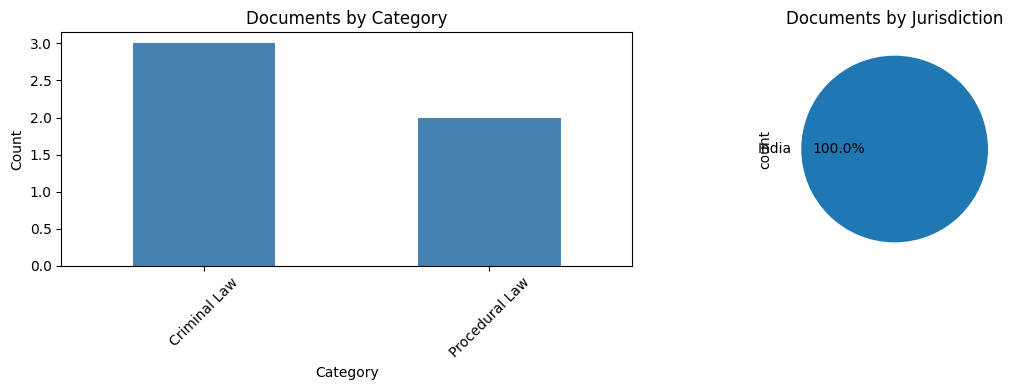

System Statistics:
Total Documents: 3
Total Chunks: 5
Embedding Dimension: 384
FAISS Index Size: 5
Average Chunk Size: 218 characters
LTM Cached Responses: 1


In [25]:
import matplotlib.pyplot as plt

# Document distribution by category
category_dist = df_chunks['category'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Category distribution
category_dist.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Documents by Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Jurisdiction distribution
jurisdiction_dist = df_chunks['jurisdiction'].value_counts()
jurisdiction_dist.plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Documents by Jurisdiction')

plt.tight_layout()
plt.show()

print("System Statistics:")
print(f"Total Documents: {len(df_documents)}")
print(f"Total Chunks: {len(df_chunks)}")
print(f"Embedding Dimension: {embedding_dim}")
print(f"FAISS Index Size: {faiss_index.ntotal}")
print(f"Average Chunk Size: {df_chunks['text'].str.len().mean():.0f} characters")
print(f"LTM Cached Responses: {ltm.stats()['cached_responses']}")

## 16. Save & Export Artifacts

In [26]:
import pickle

# Create artifacts directory
artifacts_dir = Path('../data/embeddings')
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Save FAISS index
faiss_path = artifacts_dir / 'legal_faiss_index.bin'
faiss.write_index(faiss_index, str(faiss_path))
print(f"✓ FAISS index saved to {faiss_path}")

# Save metadata
metadata_path = artifacts_dir / 'metadata.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata_map, f)
print(f"✓ Metadata saved to {metadata_path}")

# Save chunks DataFrame
chunks_path = artifacts_dir / 'chunks.csv'
df_chunks_export = df_chunks.drop(columns=['embedding'])  # Don't export embeddings in CSV
df_chunks_export.to_csv(chunks_path, index=False)
print(f"✓ Chunks saved to {chunks_path}")

# Save artifacts manifest
manifest = {
    'timestamp': datetime.now().isoformat(),
    'total_documents': len(df_documents),
    'total_chunks': len(df_chunks),
    'embedding_model': model_name,
    'embedding_dimension': embedding_dim,
    'faiss_index_size': faiss_index.ntotal
}

manifest_path = artifacts_dir / 'manifest.json'
with open(manifest_path, 'w') as f:
    json.dump(manifest, f, indent=2)
print(f"✓ Manifest saved to {manifest_path}")

print("\nAll artifacts saved successfully!")

✓ FAISS index saved to ..\data\embeddings\legal_faiss_index.bin
✓ Metadata saved to ..\data\embeddings\metadata.pkl
✓ Chunks saved to ..\data\embeddings\chunks.csv
✓ Manifest saved to ..\data\embeddings\manifest.json

All artifacts saved successfully!


In [ ]:
# Ingest the full legal database into a notebook bot instance for richer context
from pathlib import Path
import json
import uuid
from src.core.chatbot import LegalAdvisorBot

print("Preparing to ingest legal database into bot...")

bot = LegalAdvisorBot()
notebook_session_id = f"notebook_{uuid.uuid4().hex[:8]}"
bot.start_session(notebook_session_id)

legal_db_path = Path("../data/legal_database/legal_sections.json")
if not legal_db_path.exists():
    print(f"Legal database file not found at: {legal_db_path.resolve()}")
else:
    with open(legal_db_path, 'r', encoding='utf-8') as f:
        legal_sections = json.load(f)

    docs = []
    metadata_list = []
    for sec in legal_sections:
        if not sec:
            continue
        title = sec.get('title') or sec.get('id')
        content = sec.get('content', '')
        doc_text = f"{title}\n\n{content}"
        docs.append(doc_text)
        metadata_list.append({
            'id': sec.get('id'),
            'title': title,
            'category': sec.get('category'),
            'year': sec.get('year'),
            'jurisdiction': sec.get('jurisdiction')
        })

    print(f"Loaded {len(docs)} documents from legal database; ingesting into bot...")
    bot.ingest_legal_documents(docs, metadata_list)
    print(f"✅ Ingested {len(docs)} legal sections into bot session: {notebook_session_id}")

    # Simple verification: ask a test query using the bot instance
    test_query = "What is the punishment for cheating under Section 420?"
    try:
        resp = bot.query(test_query, session_id=notebook_session_id)
        print("\nSample query executed against notebook bot:\n")
        print(f"Query: {test_query}")
        print(f"Response (truncated): {str(resp.get('response', ''))[:400]}...")
        print(f"Retrieved docs: {resp.get('retrieved_count', 'N/A')}")
    except Exception as e:
        print(f"Error running sample query: {e}")
